In [ ]:
# !pip install scikeras>=0.1.8
# !pip install tensorflow>=2.3.0
# !pip install -U skorch
# !pip install torch
# !pip install torchvision
# !pip install pytorch-cpu #not sure if i need to fix this
# !pip install s3fs
# !pip install dask_kubernetes

In [ ]:
# !pip install cloudpickle==2.1.0
# !pip install dask==2022.05.0
# !pip install distributed==2022.5.0
# !pip install lz4==4.0.0
# !pip install msgpack==1.0.3
# !pip install toolz==0.11.2
# !pip install xgboost

In [1]:
import dask
# Dask multithreading is only suited for mostly non-Python code (like pandas, numpy, etc.)
#tag::threads[]
dask.config.set(scheduler='threads')
#end::threads[]
#tag::process[]
dask.config.set(scheduler='processes')
#end::process[]
#tag::dask_use_forkserver[]
dask.config.set({"multiprocessing.context": "forkserver", "scheduler": "processes"})
#end::dask_use_forkserver[]

In [ ]:
# !export

In [54]:
# #tag::make_dask_k8s_client[]
# import dask
# from dask.distributed import Client
# from dask_kubernetes import KubeCluster, make_pod_spec
# # Use load balancer to make it externally available, for purely internal
# # the default of "ClusterIP" is better.
# dask.config.set({"kubernetes.scheduler-service-type": "LoadBalancer"})
# worker_template = make_pod_spec(image='holdenk/dask:latest',
#                          memory_limit='8G', memory_request='8G',
#                          cpu_limit=1, cpu_request=1)
# scheduler_template = make_pod_spec(image='holdenk/dask:latest',
#                          memory_limit='4G', memory_request='4G',
#                          cpu_limit=1, cpu_request=1)
# cluster = KubeCluster(pod_template = worker_template, scheduler_pod_template = scheduler_template)
# # cluster.adapt()    # or create and destroy workers dynamically based on workload
# from dask.distributed import Client
# client = Client(cluster)
# #end::make_dask_k8s_client[]
# client

Creating scheduler pod on cluster. This may take some time.


Connection method: Cluster object,Cluster type: dask_kubernetes.KubeCluster
Dashboard: http://23.177.16.207:56220/status,
Dashboard: http://23.177.16.207:56220/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.42.9.37:8786,Workers: 0
Dashboard: http://10.42.9.37:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [1]:
from dask.distributed import Client
# when working with clusters, specify cluster config, n_workers and worker_size
client = Client(n_workers=3, 
                       threads_per_worker=1,
                       memory_limit=0)
#my machine currently has chunking issues. Overriding for one worker only for now. 
#This is a good deep dive for a blog post on chunking troubleshooting.

C:\ProgramData\Anaconda3\lib\site-packages\distributed\node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 59836 instead
  warnings.warn(


In [2]:
import dask.dataframe as dd


In [23]:
# filename = 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2013-01.parquet'
filename = './nyc_taxi/yellow_tripdata_2013-01.parquet'
# filename = './nyc_taxi/yellow_tripdata_2019-01.parquet'
df = dd.read_parquet(
    filename
    ,
    chunksize=50000
)
#Chunksize might be deprecated in future.

In [4]:
df.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
RatecodeID                        int64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge             object
airport_fee                      object
dtype: object

In [13]:
df.shape

(Delayed('int-8496c7f7-f776-4f17-98d2-fc5249e2a998'), 19)

In [16]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
npartitions=1,,,,,,,,,,,,,,,,,,,
,int64,datetime64[ns],datetime64[ns],int64,float64,int64,object,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,object,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [5]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2013-01-01 00:39:00,2013-01-01 00:55:00,3,3.86,1,None,238,116,2,15.0,0.5,0.5,0.00,0.0,0.0,16.00,None,None
1,2,2013-01-01 00:12:00,2013-01-01 00:16:00,5,0.00,1,None,264,264,1,3.5,0.5,0.5,0.12,0.0,0.0,4.62,None,None
2,2,2013-01-01 00:02:00,2013-01-01 00:03:00,3,0.00,1,None,264,264,1,2.5,0.5,0.5,0.25,0.0,0.0,3.75,None,None
3,2,2013-01-01 00:38:00,2013-01-01 00:38:00,2,0.00,1,None,264,264,2,2.5,0.5,0.5,0.00,0.0,0.0,3.50,None,None
4,2,2013-01-01 00:03:00,2013-01-01 00:04:00,4,0.00,1,None,264,264,1,3.0,0.5,0.5,0.07,0.0,0.0,4.07,None,None


In [16]:
#remember dask ddf is just pandas df
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)
df.describe(percentiles = [.25, .5, .75]).compute()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration_check
count,14776617.00000,14776617.00000,14776617.00000,14776617.00000,14776617.00000,14776617.00000,14776617.00000,14776617.00000,14776617.00000,14776617.00000,14776617.00000,14776617.00000,14776617.00000,14776617.00000,14776617.00000
mean,1.49576,1.69737,2.77098,1.03874,163.64319,161.87711,1.48098,11.66472,0.32049,0.49840,1.26751,0.20187,0.00000,13.95299,694.53914
std,0.49998,1.36540,3.30592,0.72853,67.24272,70.13017,0.51365,9.63922,0.36757,0.02827,2.04608,1.03548,0.00011,11.46469,24465.83116
min,1.00000,0.00000,0.00000,1.00000,1.00000,1.00000,1.00000,2.50000,0.00000,0.00000,0.00000,0.00000,0.00000,2.50000,-29589.00000
25%,1.00000,1.00000,1.00000,1.00000,114.00000,107.00000,1.00000,6.50000,0.00000,0.50000,0.00000,0.00000,0.00000,7.70000,360.00000
50%,1.00000,1.00000,1.70000,1.00000,162.00000,162.00000,1.00000,9.00000,0.00000,0.50000,0.80000,0.00000,0.00000,10.50000,555.00000
75%,2.00000,2.00000,3.06000,1.00000,233.00000,233.00000,2.00000,13.00000,0.50000,0.50000,2.00000,0.00000,0.00000,15.50000,886.00000
max,2.00000,255.00000,100.00000,99.00000,265.00000,265.00000,5.00000,500.00000,12.50000,0.50000,200.00000,20.00000,0.30000,650.00000,69924412.00000


In [22]:
%matplotlib inline

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

In [42]:
# https://livebook.manning.com/book/data-science-at-scale-with-python-and-dask/chapter-7/
# refer to this chapter for plotting with dask + seaborn -

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


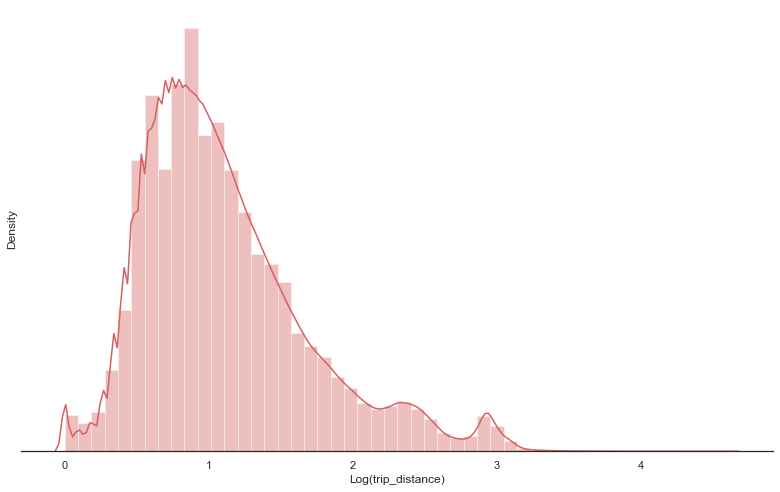

In [49]:
%matplotlib inline
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(1, 1, figsize=(11, 7), sharex=True)
sns.despine(left=True)
sns.distplot(np.log(df['trip_distance'].values+1), axlabel = 'Log(trip_distance)', label = 'log(trip_distance)', bins = 50, color="r")
plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()

In [ ]:
# Show that each col is a numpy ndarray. Note how array size is NaN until we call compute.
# chunk sizes compte also shows how this is parallelized.
df['trip_distance'].values.compute_chunk_sizes()

In [40]:
# number of rows
numrows = df.shape[0].compute()
# number of columns
numcols = df.shape[1]
print("Number of rows {} number of columns {}".format(numrows, numcols))

Number of rows 14776617 number of columns 19


In [24]:
df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).map(lambda x: x.total_seconds())

In [25]:
df['trip_duration'].describe().compute()

count   14776617.00000
mean         694.53914
std        24465.83116
min       -29589.00000
25%          360.00000
50%          555.00000
75%          886.00000
max     69924412.00000
Name: trip_duration, dtype: float64

In [20]:
duration_diff = np.abs(df['trip_duration'])

In [26]:
# clean up data as we see some dirty inputs
df = df[df['trip_duration'] <= 10000]
df = df[df['trip_duration'] >= 30]

In [27]:
df['trip_duration'].describe().compute()

count   14687141.00000
mean         687.34418
std          489.60857
min           60.00000
25%          360.00000
50%          561.00000
75%          891.00000
max         6000.00000
Name: trip_duration, dtype: float64

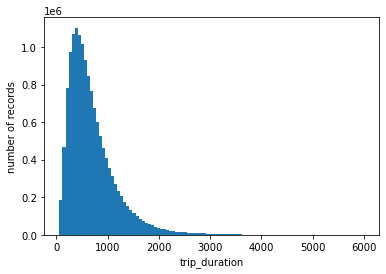

In [30]:
# note numpy -> ddf logic is slightly different. eg df[col].values vs df[col]
# visualizing whole dataset is a different fish to fry, we are just showing small ones for now.
plt.hist(df['trip_duration'], bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of records')
plt.show()

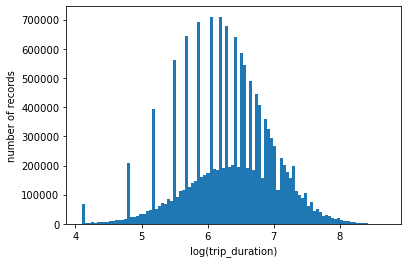

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='log_trip_duration', ylabel='Density'>

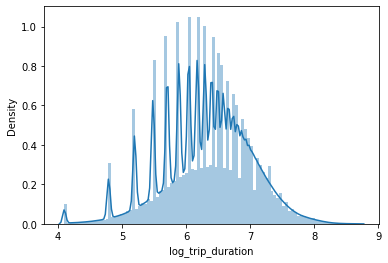

In [33]:
df['log_trip_duration'] = np.log(df['trip_duration'])
plt.hist(df['log_trip_duration'], bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of records')
plt.show()
sns.distplot(df["log_trip_duration"], bins =100)

In [ ]:
sns.despine(left=True)
sns.distplot(
    np.log(df['trip_distance'].values+1),
    axlabel = 'Log(trip_distance)', label = 'log(trip_distance)', bins = 50, color="r")
plt.setp(axes, yticks=[])


In [26]:
client.close()

In [6]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:53543/status,
Dashboard: http://127.0.0.1:53543/status,Workers: 3
Total threads: 3,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:53544,Workers: 3
Dashboard: http://127.0.0.1:53543/status,Total threads: 3
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:53574,Total threads: 1
Dashboard: http://127.0.0.1:53575/status,Memory: 0 B
Nanny: tcp://127.0.0.1:53547,
